# **CNN for Classification on CIFAR-10**

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Flatten, GlobalMaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Model

## **Load the CIFAR-10 Data**

In [0]:
cifar10 = tf.keras.datasets.cifar10

As usual, the dataset is split into training set and test set.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('shape of x_train',x_train.shape)
print('shape of y_train',y_train.shape)

170500096/170498071 [==============================] - 11s 0us/step
shape of x_train (50000, 32, 32, 3)
shape of y_train (50000, 1)


First, let's see how the images look like, show few examples of the data set. We identify the representation of labels from the description of the CIFAR-10 dataset.

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

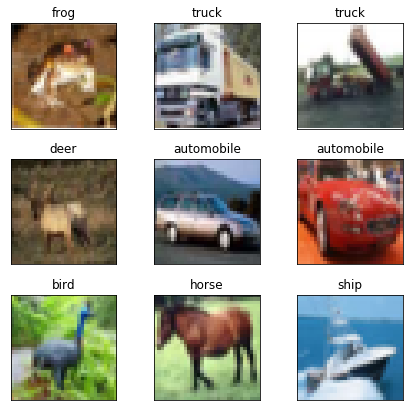

In [7]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i])
  plt.title(class_names[y_train[i,0]])
  plt.xticks([])
  plt.yticks([])
plt.rcParams['figure.figsize']=[6,6]

## **Data Pre-Processing**
The CIFAR-10 dataset is a color image dataset, which means for each image, it has 3 dimensions, the value of each pixel is range from 0 to 255. So, most commonly, we scale the value of pixels (x_train and x_test) into range 0 to 1.
<br>
<br>
 Also notice that the shape of label y_train and y_test are 2 dimension array, so before we put them into the model, we need to flatten them into 1 dimension array. 


In [8]:
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print('shape of x_train',x_train.shape)
print('shape of y_train', y_train.shape)

shape of x_train (50000, 32, 32, 3)
shape of y_train (50000,)


Determine the number of classes.

In [9]:
K = len(set(y_train))
print('number of unique classes:',K)

number of unique classes: 10


## **Build CNN Model**
Now, Let's build our CNN model by using the functional API.
<br>
<br>
The model we will build has three convolution layers and follow the pattern of increasing the output feature maps at each subsequent convolution layer. The filter size is fixed as 3 x 3 with stride size 2. We use relu as the activation function as usual.
<br>
<br>
After 3 convolution layers we flatten the feature images so that the input of the following dense layer is a feature vector. 
<br>
<br>
Fanally, we add some dropout layers for regularization. Since we have K=10 classes, so the activation function for output layer is softmax function.
<br>
<br>
Since the dataset is very large, we should enable GPU acceleration before train the CNN model.

In [10]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
i = Input(x_train[0].shape)
x = Conv2D(32, (3,3), strides=2, activation='relu')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10,activation='softmax')(x)

After we have all input and output, we pass the input and output into a model constructor. The first argument of the model constructor is a list of the input or a single input, the second argument is a list of output or a single output.

In [0]:
model = Model(i, x)

We compile the model with Adam as the optimization algorithm, cross entropy as the loss function and accuracy as the evaluation metric. We train the model with training set for 15 epoch and evaluate the model using test set.

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=15)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 15s 307us/sample - loss: 1.5934 - accuracy: 0.4168 - val_loss: 1.3323 - val_accuracy: 0.5347
Epoch 2/15
50000/50000 [==============================] - 8s 167us/sample - loss: 1.2931 - accuracy: 0.5333 - val_loss: 1.1316 - val_accuracy: 0.5908
Epoch 3/15
50000/50000 [==============================] - 8s 166us/sample - loss: 1.1716 - accuracy: 0.5801 - val_loss: 1.0622 - val_accuracy: 0.6219
Epoch 4/15
50000/50000 [==============================] - 8s 167us/sample - loss: 1.0873 - accuracy: 0.6097 - val_loss: 0.9865 - val_accuracy: 0.6514
Epoch 5/15
50000/50000 [==============================] - 9s 174us/sample - loss: 1.0290 - accuracy: 0.6352 - val_loss: 0.9533 - val_accuracy: 0.6669
Epoch 6/15
50000/50000 [==============================] - 8s 170us/sample - loss: 0.9851 - accuracy: 0.6487 - val_loss: 0.9316 - val_accuracy: 0.6699
Epoch 7/15
50000/50000 [=========================

The accuracy for validation data (test set) is 72%, accuracy of training set is 73%. Since it is a more complicate dataset compare with the Fashion MNIST or MNIST Digits, so the results is fine. Now, let's plot the loss and accuracy.

Text(0, 0.5, 'loss')

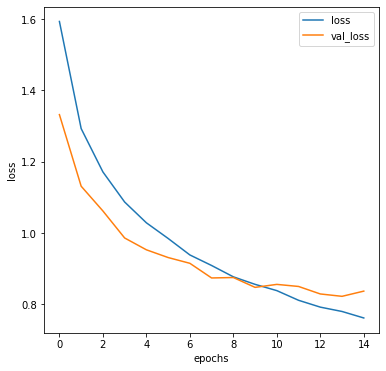

In [14]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

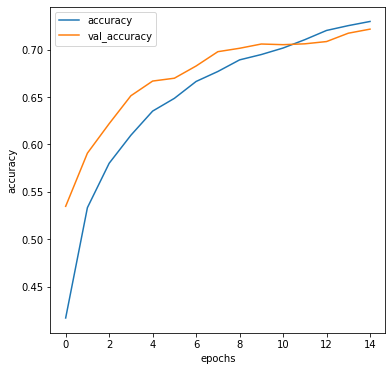

In [15]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

## **Improving of CNN for CIFAR-10**
Although the accuracy of training set and test set are very close, which means there is not much overfitting of the model, still there is space that we can improve our model.The improvment can be done in two aspect.
<br>
<br>
First, on the model, we can add batch-normalization between each convolution layer. The batch-normalization can reduce the chance of overfitting since it prevent the model from learning on the noise.
<br>
<br>
Second, on the data, we can apply data augmentation before we start to train the model. The augmentation  includes but not limit to shifting, rotation, flip, zoom, which more data are created so that it prevent overfitting.

Now, let's rebuild our CNN model with batch-normalization between convolution layer, also, since we will have more convolution layers this time, the stride size is set to 1 and the zero padding is applied after the convolution layer to keep the image size the same with before image convolution, after 2 same size convolution layers, apply the maxpooling to extract the features.

In [0]:
i = Input(x_train[0].shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10,activation='softmax')(x)

In [0]:
model2 = Model(i,x)

In [0]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [45]:
r2 = model2.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 14s 280us/sample - loss: 1.5009 - accuracy: 0.4686 - val_loss: 1.0464 - val_accuracy: 0.6265
Epoch 2/20
50000/50000 [==============================] - 13s 254us/sample - loss: 1.0187 - accuracy: 0.6447 - val_loss: 0.8588 - val_accuracy: 0.6983
Epoch 3/20
50000/50000 [==============================] - 12s 249us/sample - loss: 0.8498 - accuracy: 0.7102 - val_loss: 0.7932 - val_accuracy: 0.7214
Epoch 4/20
50000/50000 [==============================] - 13s 257us/sample - loss: 0.7490 - accuracy: 0.7467 - val_loss: 0.7256 - val_accuracy: 0.7549
Epoch 5/20
50000/50000 [==============================] - 13s 260us/sample - loss: 0.6669 - accuracy: 0.7768 - val_loss: 0.6311 - val_accuracy: 0.7817
Epoch 6/20
50000/50000 [==============================] - 13s 262us/sample - loss: 0.6084 - accuracy: 0.7970 - val_loss: 0.7783 - val_accuracy: 0.7272
Epoch 7/20
50000/50000 [====================

From the results we can see that after apply the improvement on the model, the accuracy for training set and test set are both increased a lot, but the model is overfitted.
<br>
<br>
Next, let's make the improvement by data augmentation. We will only take the shifting and flip. Note that if we run this AFTER calling the previous model.fit(), it will CONTINUE training where it left off.

In [46]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r2 = model2.fit_generator(train_generator,validation_data=(x_test,y_test),steps_per_epoch=steps_per_epoch,epochs=20)

  ...
    to  
  ['...']
Train for 1562 steps, validate on 10000 samples
Epoch 1/20
1562/1562 [==============================] - 39s 25ms/step - loss: 0.6397 - accuracy: 0.7905 - val_loss: 0.6108 - val_accuracy: 0.7996
Epoch 2/20
1562/1562 [==============================] - 39s 25ms/step - loss: 0.6023 - accuracy: 0.8008 - val_loss: 0.5359 - val_accuracy: 0.8282
Epoch 3/20
1562/1562 [==============================] - 40s 25ms/step - loss: 0.5775 - accuracy: 0.8091 - val_loss: 0.5183 - val_accuracy: 0.8294
Epoch 4/20
1562/1562 [==============================] - 39s 25ms/step - loss: 0.5581 - accuracy: 0.8132 - val_loss: 0.5547 - val_accuracy: 0.8190
Epoch 5/20
1562/1562 [==============================] - 39s 25ms/step - loss: 0.5417 - accuracy: 0.8172 - val_loss: 0.5567 - val_accuracy: 0.8132
Epoch 6/20
1562/1562 [==============================] - 39s 25ms/step - loss: 0.5231 - accuracy: 0.8243 - val_loss: 0.5076 - val_accuracy: 0.8286
Epoch 7/20
1562/1562 [=============================

After we applied the data augmentation, the accuracy of test set increases, more important, there is no more overfitting of the model. I believe if we increase the number of epoch, the accuarcy of test set will increase. Let's plot the loss and accuracy.

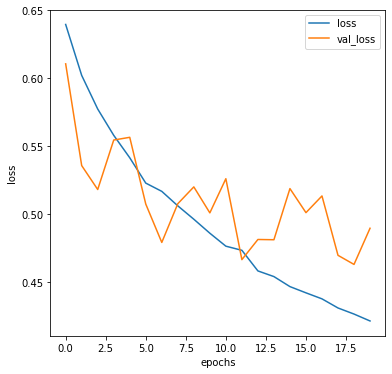

In [47]:
plt.plot(r2.history['loss'],label='loss')
plt.plot(r2.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

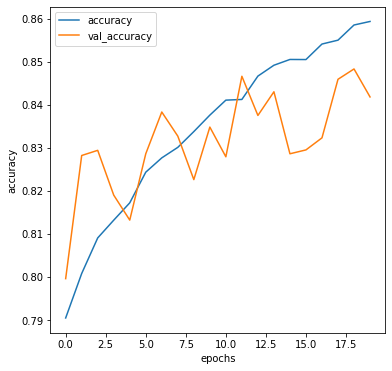

In [48]:
plt.plot(r2.history['accuracy'],label='accuracy')
plt.plot(r2.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

## **Evaluation**
Now, we generate a confusion matrix.

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

We predict the result using test data, using the improved version model.

In [0]:
y_pred = model2.predict(x_test).argmax(axis=1)

Since the prediction results for each sample is an numpy array of probabilities,we just pick the one with the largest probability, its index as the predicted label.

Confusion matrix, without normalization
[[895  10  18   7   6   1  12  10  25  16]
 [  9 946   0   2   0   0   4   0   4  35]
 [ 68   0 720  39  32  20  89  18   6   8]
 [ 31   4  35 717  24  40  98  27  10  14]
 [ 10   0  24  36 825   4  64  32   4   1]
 [ 14   1  33 137  32 673  60  41   1   8]
 [  9   0   7  14  10   0 955   4   0   1]
 [ 16   3   9  31  26  16  17 875   2   5]
 [ 62  16   2   7   3   1   4   1 887  17]
 [ 15  33   1   6   0   0   5   5  10 925]]


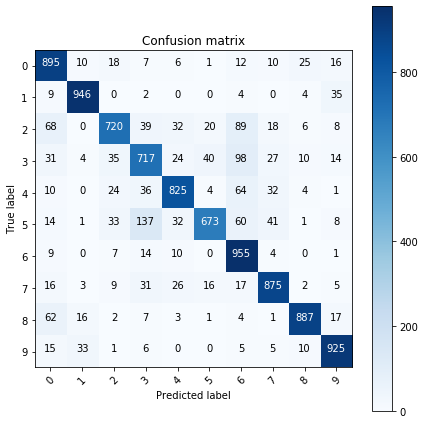

In [52]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,classes=list(range(10)))

From the confusion matrix we can see the most misclassified labels are true label 5 with predicted label 3, and true label 3 with predicted label 6. Recall that the label 3 is cat, label 5 is dog, label 6 is frog, which make sense for this dataset, since the images are really small and they are very similar by looking at this dataset.

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Now, let's see few examples of correctly and incorrectly classified images.

In [0]:
misclassified_idx = np.where(y_pred != y_test)[0]
correctclassified_idx = np.where(y_pred == y_test)[0]

In [61]:
print('Correctly classified number:',correctclassified_idx.shape[0])
print('Misclassified number:',misclassified_idx.shape[0])

Correctly classified number: 8418
Misclassified number: 1582


In [0]:
i_incorct = np.random.choice(misclassified_idx,(1,5))[0]
i_corct = np.random.choice(correctclassified_idx,(1,5))[0]

In [73]:
i_incorct

array([1439, 7518, 5298, 2060, 2161])

Show the images that are correctly classified.

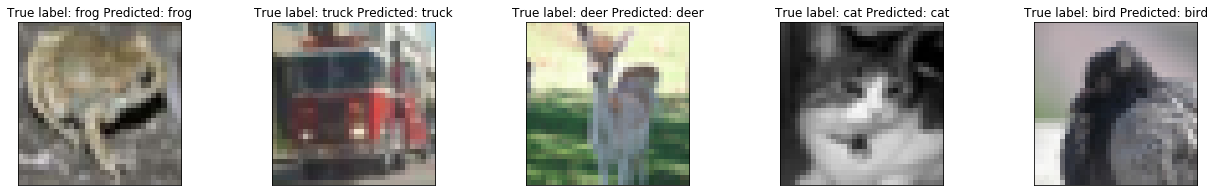

In [74]:
fig_corct = plt.figure()

for i,correct in enumerate(i_corct):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[correct])
  plt.title("True label: {} Predicted: {}".format(class_names[y_test[correct]],class_names[y_pred[correct]]))
  plt.xticks([])
  plt.yticks([])
plt.rcParams['figure.figsize'] = (22,3)

Show the images that are misclassified.

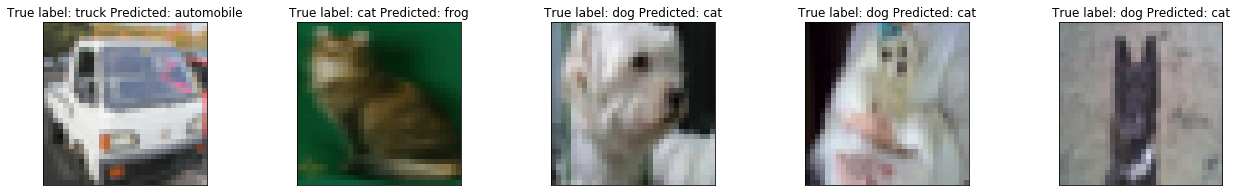

In [75]:
fig_incorct = plt.figure()

for i,incorrect in enumerate(i_incorct):
  plt.subplot(1,5,i+1)
  plt.imshow(x_test[incorrect])
  plt.title("True label: {} Predicted: {}".format(class_names[y_test[incorrect]],class_names[y_pred[incorrect]]))
  plt.xticks([])
  plt.yticks([])
plt.rcParams['figure.figsize'] = (22,3)

In summary, we build a CNN model and train it by using CIFAR-10 dataset. However, from the results we see that the simple CNN will not do a very good prediction on the test set, it is obviously that the model is overfitting, then, we applied the improvement on CNN model for 2 aspect. On the model, we added batchnormalization layers between each convolution layers, the results improved. On the data, we implement data augmentation to generate more data so that it prevents the overfitting problem, also improved the results. We looked into the confusion matrix and find out that our model is most likely to misclassify a cat as a dog and misclassify a dog as a frog. Finally, we have showed some examples for correctly classified and incorrectly classified images, by looking at the examples, those misclassified images are very difficult to make a clear classification even by human eyes. 

## **Reference**
1. https://www.tensorflow.org/tutorials/keras/classification
2. https://www.tensorflow.org/tutorials/images/cnn
3. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
4. https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
5. Udemy Tensorflow 2.0: Deep Learning and Artificial Intelligence